## 載入函式庫

In [1]:
import tensorflow as tf
from keras_segmentation.models.unet import vgg_unet
import keras
import numpy as np
import os
import cv2
import time
import matplotlib.pyplot as plt

Using TensorFlow backend.


## 解決 TensorFlow 2.0 程式出現 cuDNN failed to initialize 錯誤問題

https://davistseng.blogspot.com/2019/11/tensorflow-2.html

In [2]:
def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

solve_cudnn_error()

1 Physical GPUs, 1 Logical GPUs


## 第一次建模

* 保留所有圖片
* 沒有做退縮
* WW = 600, WL = 100
* Base Model: VGG 16
* Segmentation Model: U-Net

In [3]:
result_list = [] # 用來記錄各次建模的結果

### 查看模型架構

In [4]:
model = vgg_unet(n_classes = 2, input_height = 512, input_width = 512)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 512, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 256, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [5]:
# model = vgg_unet(n_classes = 2, input_height = 512, input_width = 512)
# model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 512, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 256, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

### 模型參數設定

In [5]:
dataset_dir = 'DATA\\WW600WL100'
input_size = 512
epochs = 100
steps_per_epoch = 512

### 訓練及評估模型

目前用來評估模型表現的指標：
* average dice score (background and ROI)
* average recall
* average precision
* global dice score (ROI)

In [5]:
model_dir = os.path.join(dataset_dir, 'model')

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print('-----建立新資料夾：' + model_dir + '-----') 

st = time.time()

target_dataset = dataset_dir
print(f'########## 即將用該資料集進行訓練：{target_dataset} ##########')

model_name = 'vgg_unet_padding0'
checkpoints_path = os.path.join(model_dir, model_name)

keras.backend.clear_session() # 銷毀當前的TF，避免舊模型/網路層混亂，並減緩內存
model = vgg_unet(n_classes = 2, input_height = input_size, input_width = input_size)

model.train(
    train_images = os.path.join(dataset_dir, 'train', 'images'),
    train_annotations = os.path.join(dataset_dir, 'train', 'annotations_kidney'),
    epochs = epochs, # default = 5
    steps_per_epoch = steps_per_epoch, # default = 512
    verify_dataset = False, # 當資料量很多時檢驗資料集會花很多時間
    checkpoints_path = checkpoints_path
)

ed = time.time()
spend_time = ed - st
print('花費時間(秒)：' + str(spend_time))
print()

-----建立新資料夾：DATA\WW600WL100\model-----
########## 即將用該資料集進行訓練：DATA\WW600WL100 ##########
Starting Epoch  0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/1
128/128 [==============================] - 56s 434ms/step - loss: 0.1564 - accuracy: 0.9526
saved  DATA\WW600WL100\model\vgg_unet_padding0.model.0
Finished Epoch 0
Starting Epoch  1
Epoch 1/1
128/128 [==============================] - 49s 382ms/step - loss: 0.0347 - accuracy: 0.9911
saved  DATA\WW600WL100\model\vgg_unet_padding0.model.1
Finished Epoch 1
Starting Epoch  2
Epoch 1/1
128/128 [==============================] - 49s 381ms/step - loss: 0.0266 - accuracy: 0.9917
saved  DATA\WW600WL100\model\vgg_unet_padding0.model.2
Finished Epoch 2


NameError: name 'evaluate_model' is not defined

In [3]:
dataset_dir = 'DATA_0811_2\\WW600WL100'
import time
from evaluate import *

st = time.time()

result = evaluate_model(
    image_dir = os.path.join(dataset_dir, 'test', 'images'), 
    label_dir = os.path.join(dataset_dir, 'test', 'annotations_tumor as kidney'), 
    checkpoints_path = 'DATA_0712\\WW600WL100\\model\\vgg_unet_padding0',
    calculate_predicting_indicators = True,
    output_predicted_result = False, 
    segment_out_predicted_region_from_original_images = False, 
    roi_description = 'tumor as kidney', 
    preds = None)

print('訓練集預測結果：')
print(f'average Dice score per case of kidney: {result[0]: .4f}')
print(f'average recall of kidney: {result[1]: .4f}')
print(f'average precision of kidney: {result[2]: .4f}')
print(f'global dice score of kidney: {result[3]: .4f}')
print('')
print('混淆矩陣：')
print(f'True Positive: {result[-4]}')
print(f'False Positive: {result[-3]}')
print(f'False Negative: {result[-2]}')
print(f'True Negative: {result[-1]}')

ed = time.time()
spend_time = ed - st
print('花費時間(秒)：' + str(spend_time))

f = open("DATA_0811_2\\patient indices of testing set - KiTS.txt", "r")
test_patient_idx = f.read().splitlines()
f.close()

dice_score_list = result[5]
print('測試集各病患的 Dice score:')
for idx, i in enumerate(dice_score_list):
    print(f'case{test_patient_idx[idx]}: {i: .4f}')

Using TensorFlow backend.


----------生成模型預測結果----------
loaded weights  DATA_0712\WW600WL100\model\vgg_unet_padding0.99


100%|████████████████████████████████████████████████████████████████████████████| 12656/12656 [12:21<00:00, 17.06it/s]


----------開始計算各項預測指標----------
目前進度：第500張照片
目前進度：第1000張照片
目前進度：第1500張照片
目前進度：第2000張照片
目前進度：第2500張照片
目前進度：第3000張照片
目前進度：第3500張照片
目前進度：第4000張照片
目前進度：第4500張照片
目前進度：第5000張照片
目前進度：第5500張照片
目前進度：第6000張照片
目前進度：第6500張照片
目前進度：第7000張照片
目前進度：第7500張照片
目前進度：第8000張照片
目前進度：第8500張照片
目前進度：第9000張照片
目前進度：第9500張照片
目前進度：第10000張照片
目前進度：第10500張照片
目前進度：第11000張照片
目前進度：第11500張照片
目前進度：第12000張照片
目前進度：第12500張照片
total case number: 12656
訓練集預測結果：
average Dice score per case of kidney:  0.9352
average recall of kidney:  0.9482
average precision of kidney:  0.9245
global dice score of kidney:  0.9378

混淆矩陣：
True Positive: 4018
False Positive: 2351
False Negative: 101
True Negative: 6186
花費時間(秒)：1429.3534791469574
測試集各病患的 Dice score:
case150:  0.9513
case151:  0.8721
case152:  0.9714
case153:  0.9634
case154:  0.9637
case155:  0.9615
case156:  0.9783
case157:  0.9720
case158:  0.9668
case159:  0.9548
case160:  0.9395
case161:  0.9587
case162:  0.8848
case163:  0.9649
case164:  0.9031
case165:  0.8992
case166:  0.9555
c

In [6]:
from evaluate import *

st = time.time()

result = evaluate_model(
    image_dir = os.path.join(dataset_dir, 'test', 'images'), 
    label_dir = os.path.join(dataset_dir, 'test', 'annotations_kidney'), 
    checkpoints_path = 'DATA\\WW600WL100\\model\\vgg_unet_padding0',
    calculate_predicting_indicators = True,
    output_predicted_result = False, 
    segment_out_predicted_region_from_original_images = False, 
    roi_name = 'kidney', 
    preds = None)

print('訓練集預測結果：')
print(f'average Dice score per case of kidney: {result[0]: .4f}')
print(f'average recall of kidney: {result[1]: .4f}')
print(f'average precision of kidney: {result[2]: .4f}')
print(f'global dice score of kidney: {result[3]: .4f}')
result_list.append(result)

ed = time.time()
spend_time = ed - st
print('花費時間(秒)：' + str(spend_time))
print()

----------生成模型預測結果----------


  0%|                                                                                        | 0/13413 [00:00<?, ?it/s]

loaded weights  DATA\WW600WL100\model\vgg_unet_padding0.99


100%|████████████████████████████████████████████████████████████████████████████| 13413/13413 [13:51<00:00, 16.13it/s]


----------開始計算各項預測指標----------
目前進度：第500張照片
目前進度：第1000張照片
目前進度：第1500張照片
目前進度：第2000張照片
目前進度：第2500張照片
目前進度：第3000張照片
目前進度：第3500張照片
目前進度：第4000張照片
目前進度：第4500張照片
目前進度：第5000張照片
目前進度：第5500張照片
目前進度：第6000張照片
目前進度：第6500張照片
目前進度：第7000張照片
目前進度：第7500張照片
目前進度：第8000張照片
目前進度：第8500張照片
目前進度：第9000張照片
目前進度：第9500張照片
目前進度：第10000張照片
目前進度：第10500張照片
目前進度：第11000張照片
目前進度：第11500張照片
目前進度：第12000張照片
目前進度：第12500張照片
目前進度：第13000張照片
total case number: 13413
訓練集預測結果：
average Dice score per case of kidney:  0.9271
average recall of kidney:  0.9371
average precision of kidney:  0.9233
global dice score of kidney:  0.9310


In [31]:
st = time.time()

preds = result[4]

_ = evaluate_model(
    image_dir = os.path.join(dataset_dir, 'test', 'images'), 
    label_dir = os.path.join(dataset_dir, 'test', 'annotations_kidney'), 
    checkpoints_path = 'DATA\\WW600WL100\\model\\vgg_unet_padding0',
    calculate_predicting_indicators = False,
    output_predicted_result = True, 
    segment_out_predicted_region_from_original_images = True, 
    roi_name = 'kidney', 
    preds = preds
)

ed = time.time()
spend_time = ed - st
print('花費時間(秒)：' + str(spend_time))
print()

花費時間： 0.0000
-----建立新資料夾：DATA\WW600WL100\test\annotations_kidney_predicted-----
---------開始輸出模型預測結果----------
目前進度：第500張照片
-----建立新資料夾：DATA\WW600WL100\test\images_only_containing_predicted_kidney-----
----------開始生成並輸出只包含模型預測區域的圖片----------
目前進度：第500張照片


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

## 第二次建模

* 將「完全沒有標記」的圖片刪除
* 沒有做退縮
* WW = 600, WL = 100
* Base Model: VGG 16
* Segmentation Model: U-Net

In [ ]:
# dataset_dir = 'DATA\\WW600WL100'
# #padding = [0]
# input_size = 512
# epochs = 100
# steps_per_epoch = 512

In [ ]:
# model_dir = os.path.join(dataset_dir, 'model')

# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)
#     print('-----建立新資料夾：' + model_dir + '-----') 

# st = time.time()

# target_dataset = dataset_dir
# print(f'########## 即將用該資料集進行訓練：{target_dataset} ##########')

# model_name = 'vgg_unet_padding0'
# checkpoints_path = os.path.join(model_dir, model_name)

# keras.backend.clear_session() # 銷毀當前的TF，避免舊模型/網路層混亂，並減緩內存
# model = vgg_unet(n_classes = 2, input_height = input_size, input_width = input_size)

# model.train(
#     train_images = os.path.join(dataset_dir, 'train', 'images'),
#     train_annotations = os.path.join(dataset_dir, 'train', 'annotations_kidney'),
#     epochs = epochs, # default = 5
#     steps_per_epoch = steps_per_epoch, # default = 512
#     verify_dataset = False, # 當資料量很多時檢驗資料集會花很多時間
#     checkpoints_path = checkpoints_path
# )

# ed = time.time()
# spend_time = ed - st
# print('花費時間(秒)：' + str(spend_time))
# print()

In [6]:
# from evaluate import *

# st = time.time()

# result = evaluate_model(
#     image_dir = os.path.join(dataset_dir, 'test', 'images'), 
#     label_dir = os.path.join(dataset_dir, 'test', 'annotations_kidney'), 
#     checkpoints_path = 'DATA\\WW600WL100\\model\\vgg_unet_padding0',
#     calculate_predicting_indicators = True,
#     output_predicted_result = False, 
#     segment_out_predicted_region_from_original_images = False, 
#     roi_name = 'kidney', 
#     preds = None)

# print('訓練集預測結果：')
# print(f'average Dice score per case of kidney: {result[0]: .4f}')
# print(f'average recall of kidney: {result[1]: .4f}')
# print(f'average precision of kidney: {result[2]: .4f}')
# print(f'global dice score of kidney: {result[3]: .4f}')
# result_list.append(result)

# ed = time.time()
# spend_time = ed - st
# print('花費時間(秒)：' + str(spend_time))
# print()

----------生成模型預測結果----------
loaded weights  DATA\WW600WL100\model\vgg_unet_padding0.99


100%|████████████████████████████████████████████████████████████████████████████| 13413/13413 [12:28<00:00, 17.93it/s]


----------開始計算各項預測指標----------
編號第151病患的CT影像張數：106
目前進度：第500張照片
目前進度：第1000張照片
編號第152病患的CT影像張數：1059
編號第153病患的CT影像張數：38
編號第154病患的CT影像張數：69
目前進度：第1500張照片
編號第155病患的CT影像張數：470
目前進度：第2000張照片
編號第156病患的CT影像張數：538
目前進度：第2500張照片
目前進度：第3000張照片
編號第157病患的CT影像張數：987
目前進度：第3500張照片
編號第158病患的CT影像張數：548
目前進度：第4000張照片
目前進度：第4500張照片
編號第159病患的CT影像張數：705
目前進度：第5000張照片
編號第160病患的CT影像張數：719
編號第161病患的CT影像張數：252
目前進度：第5500張照片
編號第162病患的CT影像張數：59
編號第163病患的CT影像張數：94
編號第164病患的CT影像張數：99
編號第165病患的CT影像張數：88
目前進度：第6000張照片
目前進度：第6500張照片
編號第166病患的CT影像張數：734
編號第167病患的CT影像張數：103
編號第168病患的CT影像張數：103
編號第169病患的CT影像張數：83
編號第170病患的CT影像張數：101
目前進度：第7000張照片
編號第171病患的CT影像張數：345
編號第172病患的CT影像張數：131
目前進度：第7500張照片
編號第173病患的CT影像張數：91
編號第174病患的CT影像張數：97
編號第175病患的CT影像張數：69
編號第176病患的CT影像張數：107
編號第177病患的CT影像張數：102
編號第178病患的CT影像張數：88
目前進度：第8000張照片
編號第179病患的CT影像張數：88
編號第180病患的CT影像張數：99
編號第181病患的CT影像張數：137
編號第182病患的CT影像張數：99
目前進度：第8500張照片
編號第183病患的CT影像張數：93
編號第184病患的CT影像張數：195
編號第185病患的CT影像張數：146
目前進度：第9000張照片
編號第186病患的CT影像張數：235
編號第187病患的CT影

## 隨機印出幾張CT影像的預測結果(訓練集)

由於之後要把訓練集中的腎臟影像作為第二階段的輸入，因此這裡是印出訓練集的預測結果(測試集在這裡只是評估模型是否能夠準確預測腎臟區域)

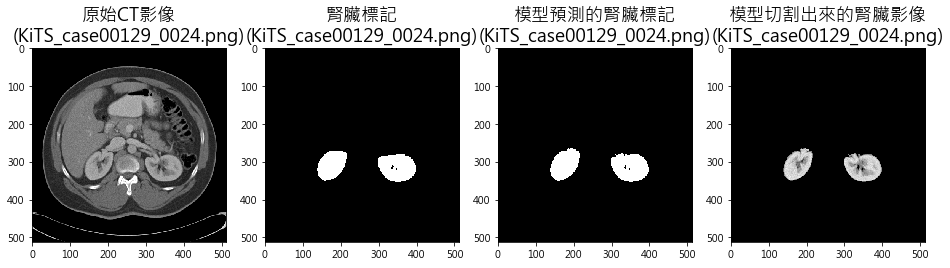

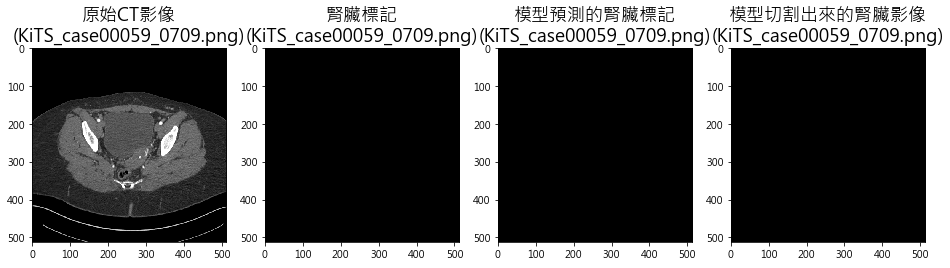

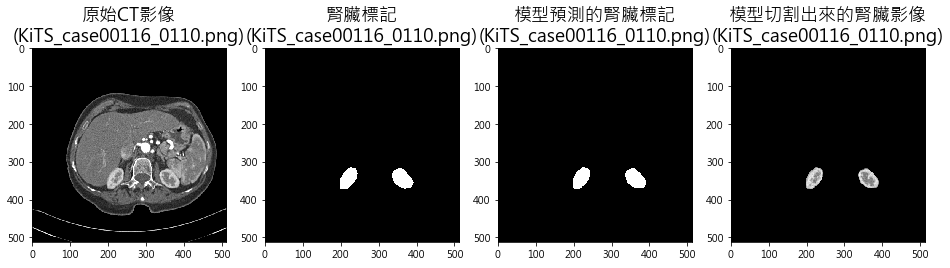

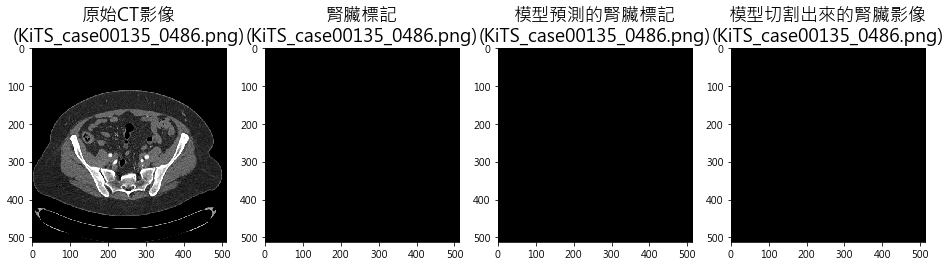

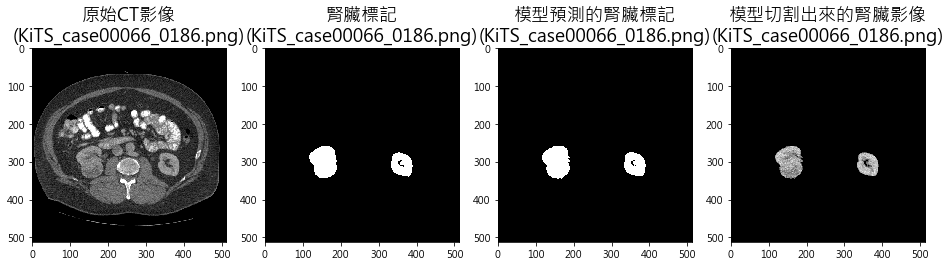

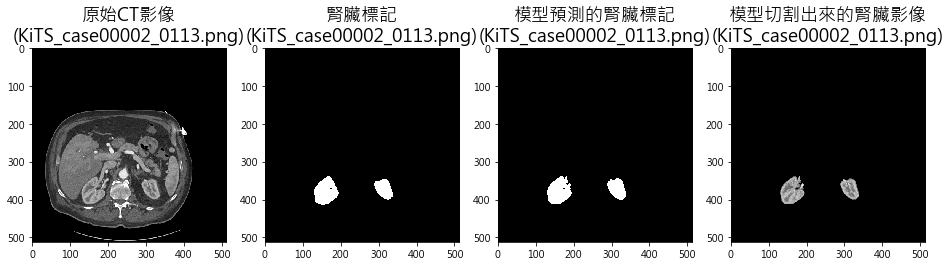

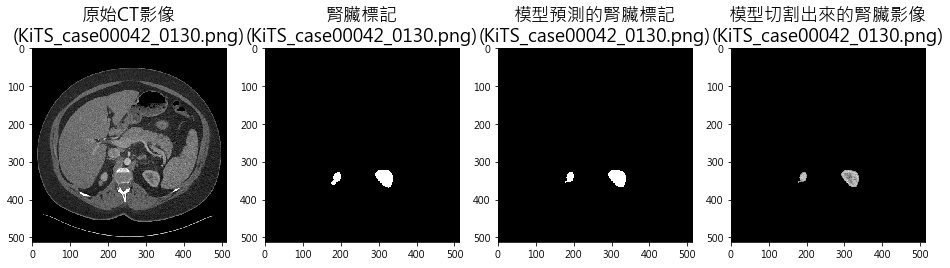

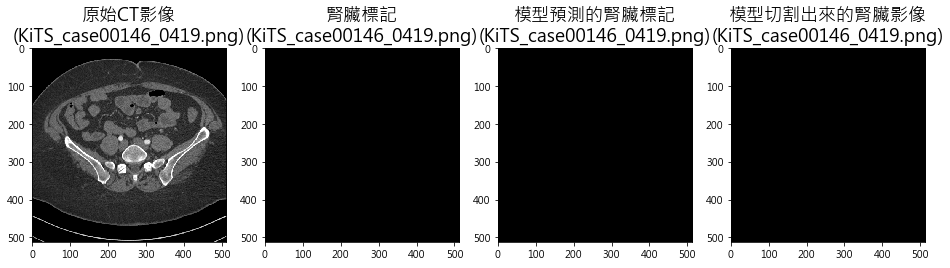

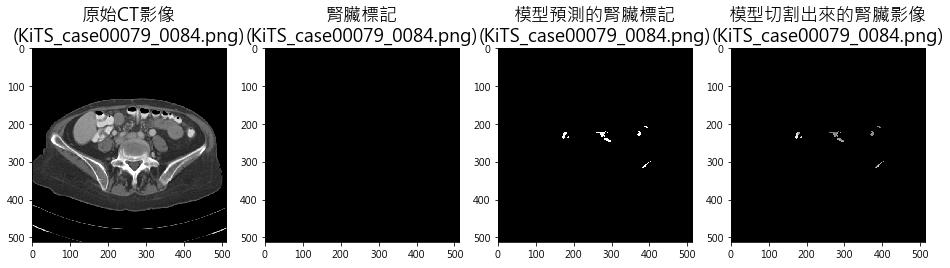

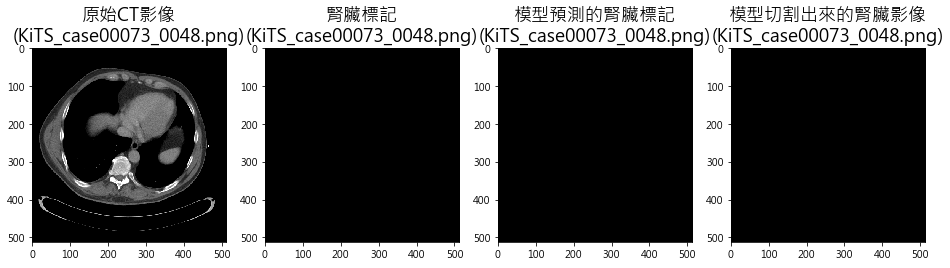

In [7]:
from evaluate import *
show_result(
    target_dataset_base_dir = 'DATA\\WW600WL100\\train',
    result_num = 10,
    roi_name = 'kidney', 
    roi_name_chinese = '腎臟',
    show_predicted_result = True,
    show_segmentation_result = True, 
    image_scale = 4)

## 隨機印出幾張CT影像的預測結果(測試集)

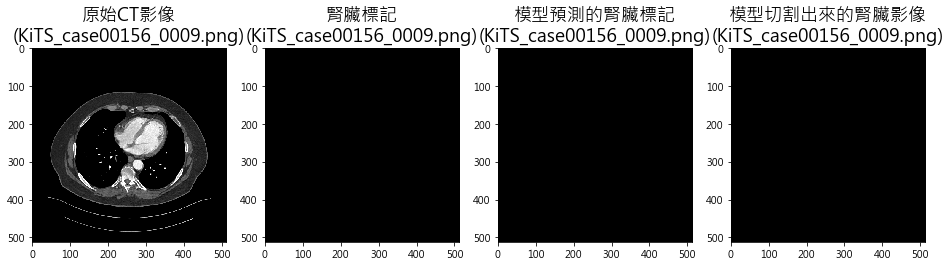

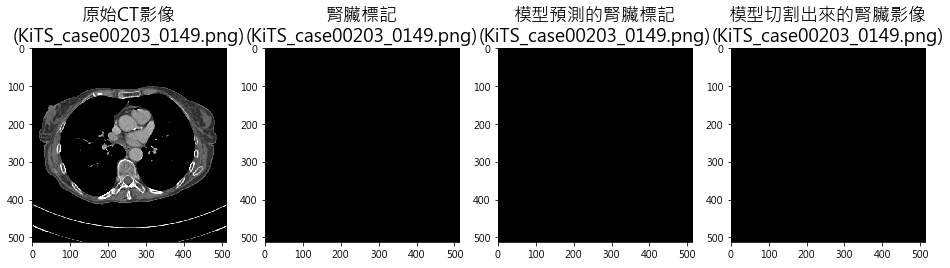

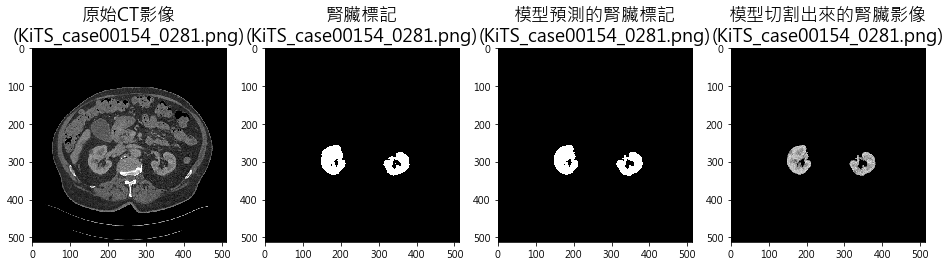

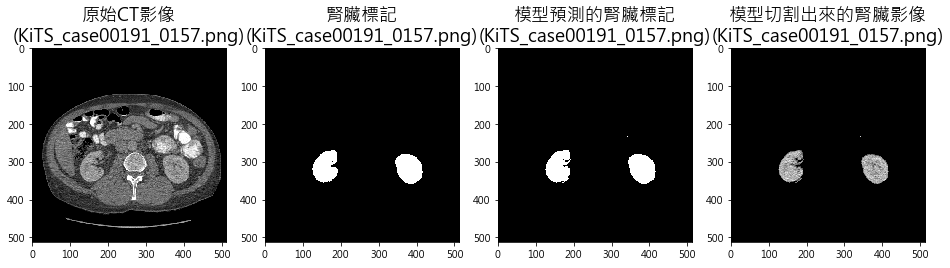

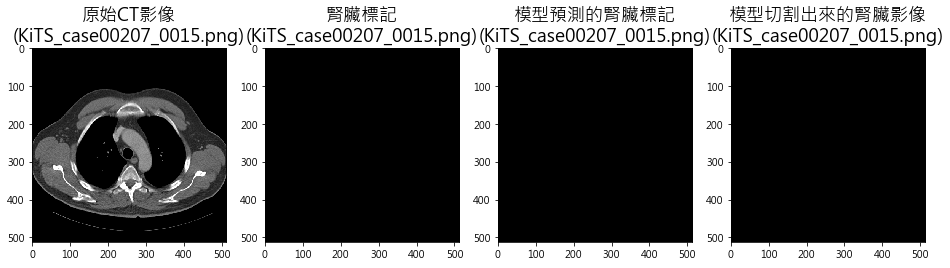

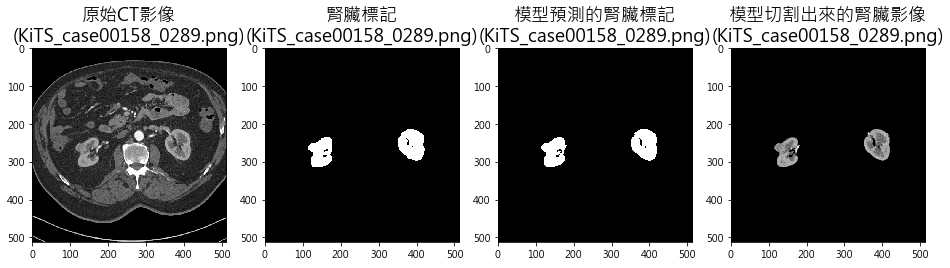

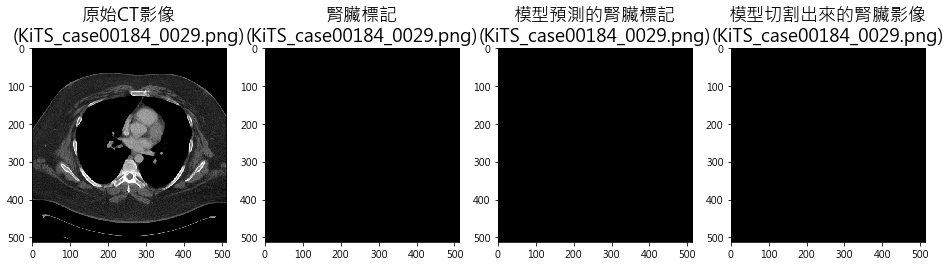

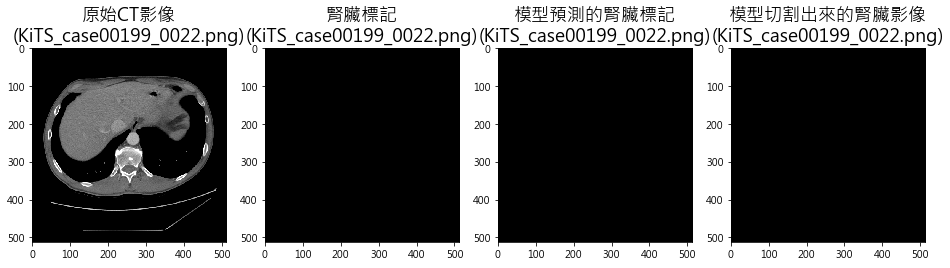

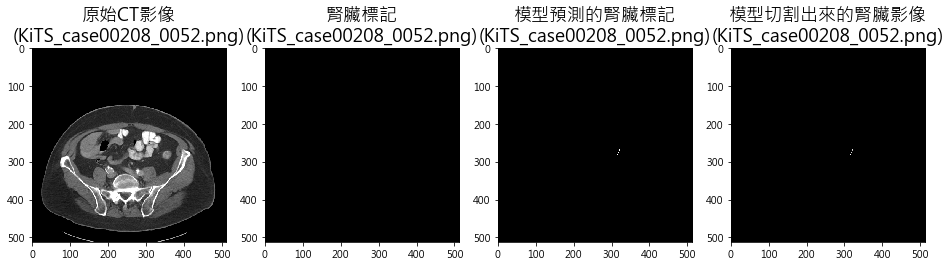

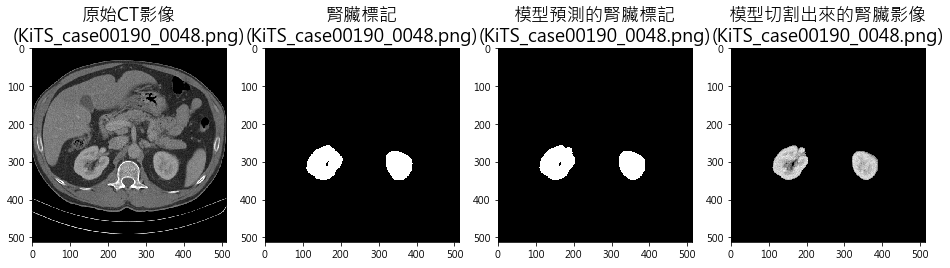

In [9]:
from evaluate import *
show_result(
    target_dataset_base_dir = 'DATA\\WW600WL100\\test',
    result_num = 10,
    roi_name = 'kidney', 
    roi_name_chinese = '腎臟',
    show_predicted_result = True,
    show_segmentation_result = True, 
    image_scale = 4)